# Demo
这是一个简化版的Mechformer的demo笔记, 我们将通过搭建一个基于gru单元的神经网络MechGRU，用于解决某种钢材的应力-应变曲线预测，即根据应变序列预测应力序列.

In [3]:
# 导入主要的包
# pytorch相关
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
# TensorDataset和DataLoader是pytorch定义的一种数据集类，可以比较方便地处理数据

# 辅助包，其中os,math,random一般由python自带
# pandas, matplotlib可通过pip或conda安装
# pip 安装：
# pip install pandas
# pip install matplotlib
# conda 安装：
# conda install pandas
# conda install matplotlib
import os
import math
import random
import pandas as pd
import matplotlib.pyplot as plt

# 如果有gpu，优先加载到gpu上进行训练
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [17]:
# 数据前处理和后处理
def data_preprocess(input_data, ref):
    """
    在这里定义对数据进行预处理的函数
    简化为除以ref的形式，也可以采用更复杂的方式
    参数:
        input_data(nn.Tensor)
    输出:
        output_data(nn.Tensor)
    """
    output_data = input_data / ref
    return output_data

def data_postprocess(input_data, ref):
    """
    在这里定义对数据进行后处理的函数，即还原到原始数据的分布
    参数:
        input_data(nn.Tensor)
    输出:
        output_data(nn.Tensor)
    """
    output_data = input_data*ref
    return output_data

# 构建数据集, 数据集是某种钢材的一批应力-应变滞回曲线，保存为csv格式
# 每个csv文件里是一条数据，其中第一列为应变值(src)，第二列为应力值(tgt)
# 第一次试验时建议不要修改以下参数
# 根据配置和读取数据量的大小，耗时1~5分钟
"""
主要参数说明
DATA_SIZE: 总数据量，最大为2000
TRAIN_SIZE: 训练集数据量，不超过2000
TEST_SIZE: 测试集数据量，除了训练数据以外的数据
SRC_SIZE: src维度，应变值为标量因此取1
TGT_SIZE: tgt维度，应力值为标量因此取1
SEQ_START: 序列的起始位置，默认为0
SEQ_LEN: 序列的总长度，本数据集的序列最大长度为1001，demo中为简化计算取512
src_ref: src的归一化参考值
tgt_ref: tgt的归一化参考值
data_path: csv数据存放路径，默认为脚本同一目录下的r'data'
注意BATCH_SIZE和SEQ_LEN一般受到显存的限制，需要根据配置调整
"""
DATA_SIZE = 2048
TRAIN_SIZE = 1920
TEST_SIZE = DATA_SIZE - TRAIN_SIZE
SRC_SIZE = 1
TGT_SIZE = 1
SEQ_START = 0
SEQ_LEN = 512
src_ref = 0.01
tgt_ref = 300
data_path = r'data'

import numpy as np
def normalize(data):
    """对数据进行归一化处理，将其缩放到[0, 1]范围"""
    min_val = torch.min(data)
    max_val = torch.max(data)
    normalized_data = (data - min_val) / (max_val - min_val + 1e-8)  # 添加一个小值以避免除以零
    return normalized_data

def read_data(data_path=data_path):
    """
    请在这里定义一个函数，读取DATA_SIZE数量的CSV文件的数据并转化为张量
    其中每个表的第一列应变值存储到srcs中，第二列应力值存储到tgts中
    参数：
        data_path(str):csv文件的存放路径，默认在同一目录下
    输出：
        srcs(nn.Tensor):输入序列，即应变路径，要求形状为(DATA_SIZE, SEQ_LEN, SRC_SIZE=1)
        tgts(nn.Tensor):输出序列，即应力路径，要求形状为(DATA_SIZE, SEQ_LEN, TGT_SIZE=1)
    提示：
        使用pandas的模块依次读取每个csv文件的数据为numpy的array，再将array转化为tensor
    """
    srcs_list = []
    tgts_list = []
    
    for i in range(1, DATA_SIZE + 1):
        file_path = os.path.join(data_path, f'data_{i}.csv')
        # 读取CSV文件
        df = pd.read_csv(file_path, header=None)
        
        # 提取应变和应力数据
        strains = df.iloc[:SEQ_LEN, 0].values
        stresses = df.iloc[:SEQ_LEN, 1].values
        
        # 转换为NumPy数组并调整形状
        strains = strains.reshape(SEQ_LEN, SRC_SIZE)
        stresses = stresses.reshape(SEQ_LEN, TGT_SIZE)
        
        srcs_list.append(strains)
        tgts_list.append(stresses)
    
    # 转换为PyTorch张量
    srcs = torch.tensor(np.array(srcs_list), dtype=torch.float32)
    tgts = torch.tensor(np.array(tgts_list), dtype=torch.float32)
    ##### your code here #####
    return srcs, tgts

# 读取数据
srcs, tgts = read_data(data_path)

# 数据预处理，做简单的归一化
srcs = normalize(srcs)
tgts = normalize(tgts)

# 检查读取数据的size，如果前后一致表明读取正确
print(f"srcs的shape: {srcs.shape}, 期望的shape: {DATA_SIZE}, {SEQ_LEN}, {SRC_SIZE}")
print(f"tgts的shape: {tgts.shape}, 期望的shape: {DATA_SIZE}, {SEQ_LEN}, {TGT_SIZE}")

srcs的shape: torch.Size([2048, 512, 1]), 期望的shape: 2048, 512, 1
tgts的shape: torch.Size([2048, 512, 1]), 期望的shape: 2048, 512, 1


In [19]:
# 划分数据
TRAIN_BATCH_SIZE = 128
TEST_BATCH_SIZE = 32

# 利用random.shuffle打乱数据以保证随机性
indices = torch.randperm(len(srcs))
srcs, tgts = srcs[indices], tgts[indices]

print(srcs.shape, tgts.shape)

# 划分训练集和测试集
##### your code here #####
src_train_data, src_test_data = srcs[:TRAIN_SIZE], srcs[-TEST_SIZE:]
tgt_train_data,  tgt_test_data = tgts[:TRAIN_SIZE], tgts[-TEST_SIZE:]

print(src_train_data.shape, tgt_train_data.shape)

train_data = TensorDataset(src_train_data, tgt_train_data)
test_data = TensorDataset(src_test_data, tgt_test_data)

# 设置DataLoader，用于分批加载数据
# 一般而言，总数据量远超计算内存，因此需要分批加载进行训练，也有助于梯度下降
##### your code here #####
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=2
)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=2
)
print(f"训练数据集批次: {len(train_loader)}，每批数据量 {TRAIN_BATCH_SIZE}")
print(f"测试数据集批次: {len(test_loader)}，每批数据量 {TEST_BATCH_SIZE}")

torch.Size([2048, 512, 1]) torch.Size([2048, 512, 1])
torch.Size([1920, 512, 1]) torch.Size([1920, 512, 1])
训练数据集批次: 15，每批数据量 128
测试数据集批次: 4，每批数据量 32


In [20]:
# 模型实现
class gruMechformer(nn.Module):
    def __init__(self, src_size=1, hidden_size=4, tgt_size=1,num_layers=1, dropout=0, activation=nn.ReLU()):
        """
        在这里初始化模型，结构为输入线性层 + GRU模块 + 输出线性层
        一般语言处理中的RNN需要embedding层将词汇转化成词表向量，这里用一个简单的线性层替代
        参数：
            src_size(int):作为输入序列的特征维度
            hidden_size(int):模型的隐层维度
            num_layers(int):GRU模块的单元层数，可取1~3
            dropout(int):GRU模块的dropout,用于防止过拟合，一般取0~0.1
            activation(nn.Module):激活函数，默认选择nn.ReLU()即可
        提示：
            设计一个输入线性层input_layer
            rnn层可调用pytorch的GRU模块
            一个输出线性层output_layer
            以及激活函数activation
        """
        super().__init__()
        ##### your code here #####
        
        """
        初始化模型，结构为输入线性层 + GRU模块 + 输出线性层
        """
        
        # 输入线性层
        self.input_layer = nn.Linear(src_size, hidden_size)
        
        # GRU模块
        self.gru = nn.GRU(input_size=hidden_size, hidden_size=hidden_size, num_layers=num_layers, 
                          dropout=dropout, batch_first=True)
        
        # 输出线性层
        self.output_layer = nn.Linear(hidden_size, tgt_size)
        
        # 激活函数
        self.activation = activation

 
    def forward(self, src):
        """
        在这里定义模型的forward函数
        参数：
            src(torch.Tensor):输入张量，即输入序列，初始形状需为[batch_size, seq_len, src_size]，其中
            batch_size:输入每个batch的size
            seq_len:输入序列的长度
            src_size:src序列的特征维度
        输出：
            output(torch.Tensor):形状为[batch_size, seq_len, tgt_size]
        提示：
            输入-线性层-激活函数（可选）-rnn层-激活函数（可选）-线性层-输出
        """
        ##### your code here #####
        # 通过输入线性层
        x = self.input_layer(src)
        # 应用激活函数（可选）
        x = self.activation(x)
        # 通过 GRU 模块
        x, _ = self.gru(x)
        # 应用激活函数（可选）
        x = self.activation(x)
        # 通过输出线性层
        output = self.output_layer(x)
        return output

In [21]:
# 定义训练函数
def train(model, data_loader, optimizer, lr_scheduler, num_epochs, criterion, num_log):
    """
    在这里定义一个训练模块函数
    参数：
        model(nn.Module):模型
        data_loader(DataLoader):用于加载训练数据的loader
        optimizer:训练的优化器
        lr_scheduler: 训练learning rate的调整器
        criterion:计算loss的损失函数
        num_epochs:训练的轮次（所有数据训练一遍作为一轮）
        num_log: 每隔num_log个batch输出当前的训练loss
    输出：
        train_loss(list[float]):记录每个step的训练loss的列表
    提示：
        对轮次进行循环，每个轮次对数据批次进行循环
    """
    model.train()
    train_loss = []
    for epoch in range(num_epochs):
        for batch_idx, (src, tgt) in enumerate(data_loader):
            ##### your code here #####
            ##### you need to calculate loss #####
            # 将数据传输到设备上（如果使用 GPU，请确保将数据移到 GPU）
            src, tgt = src.to(next(model.parameters()).device), tgt.to(next(model.parameters()).device)
            # 清零优化器的梯度
            optimizer.zero_grad()
            # 前向传播
            output = model(src)
            # 计算损失
            loss = criterion(output, tgt)
            # 反向传播
            loss.backward()
            # 更新模型参数
            optimizer.step()
            
            # 更新学习率
            lr_scheduler.step()
            
            # 记录损失            
            train_loss.append(loss.item())
            
            # 输出当前训练状态
            if len(train_loss) % num_log == 0:
                print(f'[Epoch: {epoch + 1}] [Batch idx: {batch_idx + 1}] train loss: {loss.item():.4f}' )
    return train_loss

In [22]:
# 模型参数
HIDDEN_SIZE = 64  # 可以根据需要调整
NUM_LAYERS = 2    # 可以根据需要调整
DROP_OUT = 0.1    # 选择0.0、0.1或其他值

# 模型的保存路径
SAVE_NAME = 'mechgru_params.pt'

# 初始化训练参数
NUM_EPOCHS = 100              # 迭代次数
TOTAL_STEPS = TRAIN_SIZE // TRAIN_BATCH_SIZE * NUM_EPOCHS
STEP_SIZE = TOTAL_STEPS // 4
LR = 0.001                    # 初始学习率

# 初始化model和optimizer
# 选择MSELoss作为criterion(其他度量也可)
# 选择nn.Tanh()作为激活函数
# 选择lr_scheduler.StepLR作为lr_scheduler，设置step_size=STEP_SIZE
##### your code here #####
activation = nn.Tanh()  # 选择nn.Tanh()作为激活函数
# 初始化模型
model = gruMechformer(
    src_size=1, 
    hidden_size=HIDDEN_SIZE, 
    tgt_size=1, 
    num_layers=NUM_LAYERS, 
    dropout=DROP_OUT, 
    activation=activation
)
##### 如果有gpu，注意放到gpu上进行计算 #####
model.to(device)
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=0.1)

# 输出
NUM_LOG = TOTAL_STEPS // 20
print(f"总训练轮次: {NUM_EPOCHS}, 总训练步数: {TRAIN_SIZE//TRAIN_BATCH_SIZE * NUM_EPOCHS}")
print(f"学习率每{STEP_SIZE}步进行调整, 每{NUM_LOG}步输出当前loss")

总训练轮次: 100, 总训练步数: 1500
学习率每375步进行调整, 每75步输出当前loss


In [23]:
# 进行训练并保存结果
# 根据配置和训练参数，训练需要5-30分钟，若时间过长可调大batch_size,减小epochs
train_loss = train(
    model=model,
    data_loader=train_loader,  # 使用之前定义的 train_loader
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    num_epochs=NUM_EPOCHS,
    criterion=criterion,
    num_log=NUM_LOG
)
torch.save(model.state_dict( ), SAVE_NAME)

[Epoch: 5] [Batch idx: 15] train loss: 0.1034
[Epoch: 10] [Batch idx: 15] train loss: 0.0359
[Epoch: 15] [Batch idx: 15] train loss: 0.0163
[Epoch: 20] [Batch idx: 15] train loss: 0.0106
[Epoch: 25] [Batch idx: 15] train loss: 0.0077
[Epoch: 30] [Batch idx: 15] train loss: 0.0066
[Epoch: 35] [Batch idx: 15] train loss: 0.0063
[Epoch: 40] [Batch idx: 15] train loss: 0.0063
[Epoch: 45] [Batch idx: 15] train loss: 0.0058
[Epoch: 50] [Batch idx: 15] train loss: 0.0057
[Epoch: 55] [Batch idx: 15] train loss: 0.0056
[Epoch: 60] [Batch idx: 15] train loss: 0.0057
[Epoch: 65] [Batch idx: 15] train loss: 0.0054
[Epoch: 70] [Batch idx: 15] train loss: 0.0057
[Epoch: 75] [Batch idx: 15] train loss: 0.0054
[Epoch: 80] [Batch idx: 15] train loss: 0.0056
[Epoch: 85] [Batch idx: 15] train loss: 0.0057
[Epoch: 90] [Batch idx: 15] train loss: 0.0052
[Epoch: 95] [Batch idx: 15] train loss: 0.0057
[Epoch: 100] [Batch idx: 15] train loss: 0.0056


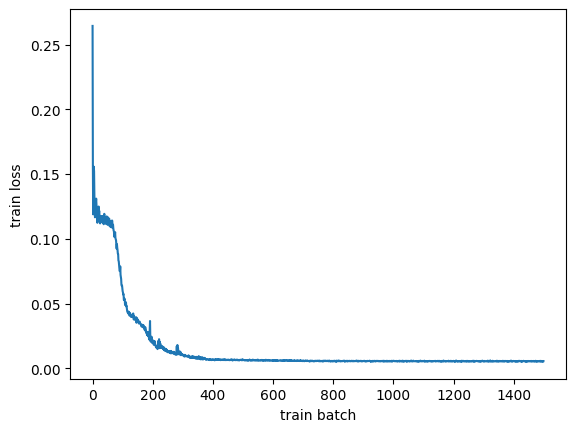

In [24]:
# 绘制训练过程的loss变化情况，一般是迅速下降-缓慢下降-收敛的曲线
plt.plot(train_loss)
plt.xlabel('train batch')
plt.ylabel('train loss')
plt.show()

In [25]:
# 定义测试函数
def test(model, data_loader, criterion):
    """
    在这里定义一个测试模块函数
    参数：
        model(nn.Module):模型
        data_loader(DataLoader):用于加载测试数据的loader
        criterion:评估测试结果的损失函数
    输出：
        eval_loss(list[float]):记录每批次测试数据的评估loss的列表
        results(list[(src, tgt, pt)]):一个列表，其中每个元素记录一个批次的src,tgt,pt，pt表示prediction
    提示：
       对数据批次进行循环
    """
    model.eval()
    eval_loss = []
    results = []
    
    for batch_idx, (src, tgt) in enumerate(data_loader):
        ##### your code here #####
        ##### you need to calculate loss and prediction #####
        src,tgt = src.to(device), tgt.to(device)
        
        prediction = model(src)
        loss = criterion(prediction, tgt)
        eval_loss.append(loss.item())
        results.append((src,tgt,prediction))
        
        # 输出当前评估结果
        print(f'[Batch idx: {batch_idx + 1}] eval loss: {loss.item():.4f}' )
        
    return eval_loss, results

In [26]:
# 加载训练的模型进行评估
saved_dict = torch.load(SAVE_NAME)
model.load_state_dict(saved_dict)
eval_loss, results = test(model, test_loader, criterion)

C:\Users\65197\AppData\Local\Temp\ipykernel_19656\2511207236.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_dict = torch.load(SAVE_NAME)


[Batch idx: 1] eval loss: 0.0046
[Batch idx: 2] eval loss: 0.0051
[Batch idx: 3] eval loss: 0.0048
[Batch idx: 4] eval loss: 0.0048


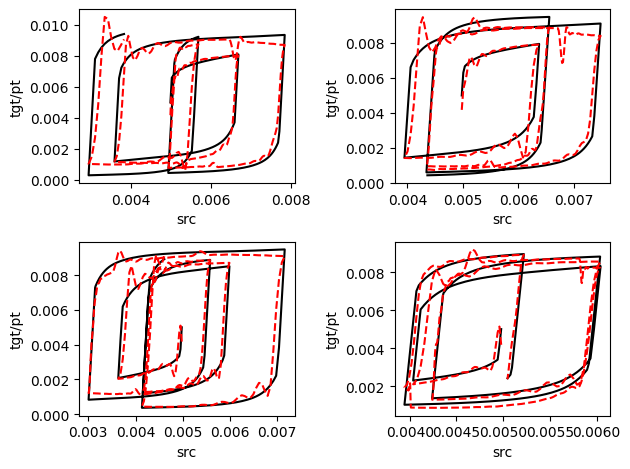

In [27]:
# 随机绘制一部分结果：
select = random.sample(results, 4)
for i in range(4):
    plt.subplot(2,2,i+1)
    
    # 还原为初始数据分布
    src, tgt, pt = select[i]
    src = data_postprocess(src, src_ref)
    tgt = data_postprocess(tgt, src_ref)
    pt =data_postprocess(pt, src_ref)
    
    # 转化成numpy的array方便绘图
    src = src[0, :, 0].cpu().numpy()
    tgt = tgt[0, :, 0].cpu().numpy()
    pt = pt[0, :, 0].detach().cpu().numpy()
    
    # 理论曲线用黑色实线表示
    plt.plot(src, tgt, color='black', linestyle='solid', label='target')
    # 预测曲线用红色虚线表示
    plt.plot(src, pt, color='red', linestyle='dashed', label='prediction')
    plt.xlabel('src')
    plt.ylabel('tgt/pt')
plt.tight_layout()
plt.show()

# 更多思考
请思考并试验以下因素对模型效果的影响，尝试进一步优化模型:

1、数据方面：数据选取，数据量，数据集划分，序列长度，数据预处理方法等

2、模型方面：模型参数（hidden_size)，GRU层数（num_layers)，模型结构，是否有线性层，激活函数等

3、训练方面：每批数据量（batch_size），训练轮次（num_epochs)，初始学习率（LR)，学习率调整策略，优化器选择等

4、力学方面：结合预测曲线和理论结果的差异，分析如何使模型更好地模拟力学行为。

欢迎各位保持交流，谢谢！